Da implementare un framework per cui si vedono i vantaggi dello spectral prunin rispetto al pruning nello spazio diretto 
c'è quasi tutto, manca ancora un modulo per avere il modello nello spazio diretto col pruning dato un modello multilayer
consiglio di modificare la funzione per il fit in modo che non stampi il risultato a


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from Spectral_Layer import Spectral
from tqdm import trange

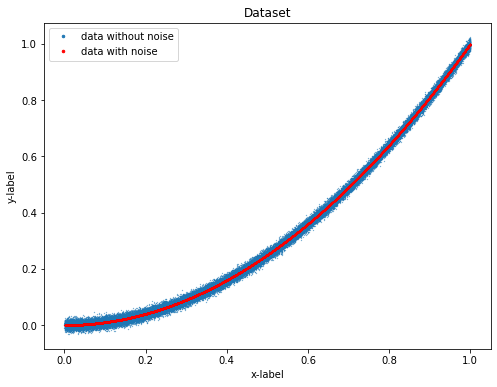

In [2]:
alpha = 2. 
sigma = 0.01
size = 70000

x = np.linspace(0, 1, size)
z = np.random.normal(0, sigma, size)  # noise
t = x**alpha
y = t + z   # add noise

X = []
Y = []
for i in range(size):
    X.append([x[i]])
    Y.append([y[i]])
    
X = np.array(X)
Y = np.array(Y)

plt.figure (figsize = (8, 6))
plt.plot(X, Y, marker='.', linestyle = '', label='data without noise', markersize=0.5)
plt.plot(x, t, marker='.', linestyle='', color='red', label='data with noise', markersize=0.5)
plt.title('Dataset')
plt.legend(markerscale=10.)
plt.xlabel('x-label')
plt.ylabel('y-label')
plt.show()

In [3]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from tcorch.utils.data import random_split

X = torch.from_numpy(X)
Y = torch.from_numpy(Y)

# Define dataset
dataset = TensorDataset(X, Y)
train_ds, val_ds, test_ds = random_split(dataset, [50000, 10000, 10000])

# Define data loader
batch_size = 1500
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size)
test_dl = DataLoader(test_ds, batch_size)

In [4]:
# Spectral Regression model with a pruning method
config = {'base_grad' : False,
         'start_grad' : True,
         'end_grad' : True,
         'bias': False}

class PruningRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.spectralin = Spectral(1, 20, **config)
        self.spectral1 = Spectral(20, 20, **config)
        self.spectral2 = Spectral(20, 20, **config)
        self.spectralout = Spectral(20, 1, **config)
    
    def forward(self,x):
        out = self.spectralin(x)  # Imput: first linear transformation
        out = self.spectral1(out) # Linear transformation
        out = F.elu(out)   # Non linear filter
        out = self.spectral2(out) # Linear transformation
        out = F.elu(out)   # Non linear filter
        out = self.spectralout(out)  # Last linear transformation: output
        return out
    
    def training_step(self, batch):
        x, y = batch 
        out = self(x)                  # Generate predictions
        loss = F.mse_loss(out, y) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        x, y= batch 
        out = self(x)                    # Generate predictions
        loss = F.mse_loss(out, y)   # Calculate loss
        return {'val_loss': loss}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.6f}".format(epoch, result['val_loss']))
        
    # This method act directly on this class
    def pruning(self, 
                perc: float, 
                start_grad: bool = False, 
                end_grad: bool = False, 
                base_grad: bool = True):
        
        self.spectralin.pruning_diag(perc, start_grad, end_grad, base_grad)
        self.spectral1.pruning_diag(perc, start_grad, end_grad, base_grad)
        self.spectral2.pruning_diag(perc, start_grad, end_grad, base_grad)
        self.spectralout.pruning_diag(perc, start_grad, end_grad, base_grad)
    
    # This method create new spectral model
    def pruning_spectral_new(self,
                    perc: float,
                    start_grad: bool = False, 
                    end_grad: bool = False, 
                    base_grad: bool = True):
        layer = []
        layer.append(self.spectralin.pruning_diag_new(perc, start_grad, end_grad, base_grad))
        layer.append(self.spectral1.pruning_diag_new(perc, start_grad, end_grad, base_grad))
        layer.append(self.spectral2.pruning_diag_new(perc, start_grad, end_grad, base_grad))
        layer.append(self.spectralout.pruning_diag_new(perc, start_grad, end_grad, base_grad))
        
        return layer
                   
    # This method create new classical model
    def pruning_calssical_new(self,
                    perc: float,
                    grad: bool = True):
        
        layer = []
        layer.append(self.spectralin.pruning_direct_space_new(perc=perc, grad=grad))
        layer.append(self.spectral1.pruning_direct_space_new(perc=perc, grad=grad))
        layer.append(self.spectral2.pruning_direct_space_new(perc=perc, grad=grad))
        layer.append(self.spectralout.pruning_direct_space_new(perc=perc, grad=grad))
        
        return layer
        
pruning_model = PruningRegression()

In [5]:
# New model pruned in spectral space
config_s = {'start_grad' : True,
         'end_grad' : True,
         'base_grad' : True}

class PruningSpectralNew(PruningRegression):
    def __init__(self, per):
        super(PruningRegression, self).__init__()
        layer = pruning_model.pruning_spectral_new(per, **config_s)
        self.spectralin = layer[0]
        self.spectral1 = layer[1]
        self.spectral2 = layer[2]
        self.spectralout = layer[3]

        
# New model pruned in direct space
config_c = {'grad': True}
        
class PruningClassicalNew(PruningRegression):
    def __init__(self, per):
        super(PruningRegression, self).__init__()
        layer = pruning_model.pruning_calssical_new(per, **config_c)
        self.spectralin = layer[0]
        self.spectral1 = layer[1]
        self.spectral2 = layer[2]
        self.spectralout = layer[3]
        
        

In [6]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    #es = EarlyStopping(patience=5) # stop with patience 5
    
    with trange(epochs, desc='Progress', unit='epochs') as tepoch:
        
        for epoch in tepoch:
            
            # Training Phase 
            for batch in train_loader:
                loss = model.training_step(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            
            # Validation phase
            result = evaluate(model, val_loader)
            history.append(result)
            
            tepoch.set_postfix(loss=loss.item())
        
        # Print final result
        model.epoch_end(epoch, result)
            
            # Early stopping
            #if es.step(loss):
            #        break  

    return history, result

In [7]:
# Pre train of principal model 
args = {'lr': 0.01,
       'model': pruning_model,
       'train_loader': train_dl,
       'val_loader': val_dl,
       'opt_func': torch.optim.Adam}

history_principal, result_principal = fit(20, **args)

Progress: 100%|██████████| 20/20 [00:09<00:00,  2.18epochs/s, loss=0.000352]

Epoch [19], val_loss: 0.000371


In [8]:
# Prepare pruned model 

cuts = [10, 20, 30, 40, 50, 60, 70, 80, 90]
model_s = []
model_c = []
for p in cuts:
    model_s.append(PruningSpectralNew(per=p))
    model_c.append(PruningClassicalNew(per=p))




In [9]:
# Train spectral pruned model
history_s = []
result_s = []
for i in range(len(cuts)):
    args_s = {'lr': 0.01,
              'model': model_s[i],
              'train_loader': train_dl,
              'val_loader': val_dl,
              'opt_func': torch.optim.Adam}
    h, r = fit(20, **args_s)
    history_s.append(h)
    result_s.append(r)
    

Progress:   0%|          | 0/20 [00:00<?, ?epochs/s]

Epoch [19], val_loss: 0.000229


Progress:   0%|          | 0/20 [00:00<?, ?epochs/s]

Epoch [19], val_loss: 0.000197


Progress:   0%|          | 0/20 [00:00<?, ?epochs/s]

Epoch [19], val_loss: 0.000194


Progress:   0%|          | 0/20 [00:00<?, ?epochs/s]

Epoch [19], val_loss: 0.000177


Progress:   0%|          | 0/20 [00:00<?, ?epochs/s]

Epoch [19], val_loss: 0.000174


Progress:   0%|          | 0/20 [00:00<?, ?epochs/s]

Epoch [19], val_loss: 0.000165


Progress:   0%|          | 0/20 [00:00<?, ?epochs/s]

Epoch [19], val_loss: 0.000157


Progress:   0%|          | 0/20 [00:00<?, ?epochs/s]

Epoch [19], val_loss: 0.000160


Progress: 100%|██████████| 20/20 [00:08<00:00,  2.43epochs/s, loss=0.000286]

Epoch [19], val_loss: 0.000277


In [10]:
# Train classical pruned model
history_c = []
result_c = []
for i in range(len(cuts)):
    args_c = {'lr': 0.01,
              'model': model_c[i],
              'train_loader': train_dl,
              'val_loader': val_dl,
              'opt_func': torch.optim.Adam}
    h, r = fit(20, **args_s)
    history_c.append(h)
    result_c.append(r)

Progress:   0%|          | 0/20 [00:00<?, ?epochs/s]

Epoch [19], val_loss: 0.000250


Progress:   0%|          | 0/20 [00:00<?, ?epochs/s]

Epoch [19], val_loss: 0.000216


Progress:   0%|          | 0/20 [00:00<?, ?epochs/s]

Epoch [19], val_loss: 0.000204


Progress:   0%|          | 0/20 [00:00<?, ?epochs/s]

Epoch [19], val_loss: 0.000196


Progress:   0%|          | 0/20 [00:00<?, ?epochs/s]

Epoch [19], val_loss: 0.000189


Progress:   0%|          | 0/20 [00:00<?, ?epochs/s]

Epoch [19], val_loss: 0.000186


Progress:   0%|          | 0/20 [00:00<?, ?epochs/s]

Epoch [19], val_loss: 0.000182


Progress:   0%|          | 0/20 [00:00<?, ?epochs/s]

Epoch [19], val_loss: 0.000178


Progress: 100%|██████████| 20/20 [00:08<00:00,  2.41epochs/s, loss=0.00017] 

Epoch [19], val_loss: 0.000175


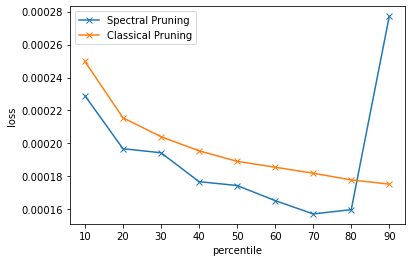

In [11]:
#losses = [result['val_loss'] for result in result_principal]
losses_s = [result['val_loss'] for result in result_s]
losses_c = [result['val_loss'] for result in result_c]

plt.plot(cuts,losses_s, '-x', label='Spectral Pruning')
plt.plot(cuts,losses_c, '-x', label='Classical Pruning')
#plt.plot(losses1, '-x', label='pruned 25%')
#plt.plot(losses2, '-x', label='pruned 50%')
#plt.plot(losses3, '-x', label='pruned 75%')
plt.xlabel('percentile')
plt.ylabel('loss')
plt.legend()

plt.show()

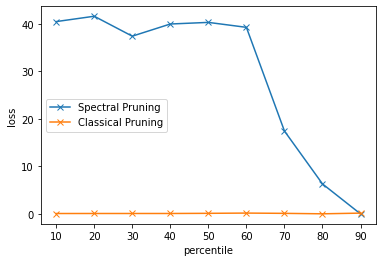

In [12]:
# Prediction on test tadaset

t_c = [evaluate(model_c[i], test_dl) for i in range(len(cuts))]
t_s = [evaluate(model_s[i], test_dl) for i in range(len(cuts))]

test_c = [t_c[i]['val_loss'] for i in range(len(cuts))]
test_s = [t_s[i]['val_loss'] for i in range(len(cuts))]

plt.plot(cuts,test_s, '-x', label='Spectral Pruning')
plt.plot(cuts,test_c, '-x', label='Classical Pruning')
plt.xlabel('percentile')
plt.ylabel('loss')
plt.legend()

plt.show()

#print("Results obtained on the test dataset...")
#print("Loss for non pruned model: {:.3} ".format(ris_non_pruned['val_loss']))
#print("Loss for model pruned 25%: {:.3} ".format(ris_pruned1['val_loss']))
#print("Loss for model pruned 50%: {:.3} ".format(ris_pruned2['val_loss']))
#print("Loss for model pruned 75%: {:.3} ".format(ris_pruned3['val_loss']))

